# ETL TIP


### IMPORTACION LIBRERIAS

In [2]:

import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
import os
import json
import ast
import gzip
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
import wordcloud
from wordcloud import WordCloud, STOPWORDS
from datetime import datetime

In [3]:
# Leer el archivo Parquet y cargarlo en un DataFrame
df_tip = pd.read_parquet(r"../../data/raw/yelp/tip.parquet")

# Mostrar las primeras filas para verificar la carga
print(df_tip.head())

                  user_id             business_id  \
0  AGNUgVwnZUey3gcPCJ76iw  3uLgwr0qeCNMjKenHJwPGQ   
1  NBN4MgHP9D3cw--SnauTkA  QoezRbYQncpRqyrLH6Iqjg   
2  -copOvldyKh1qr-vzkDEvw  MYoRNLb5chwjQe3c_k37Gg   
3  FjMQVZjSqY8syIO-53KFKw  hV-bABTK-glh5wj31ps_Jw   
4  ld0AperBXk1h6UbqmM80zw  _uN0OudeJ3Zl_tf6nxg5ww   

                                                text                date  \
0                     Avengers time with the ladies. 2012-05-18 02:17:21   
1  They have lots of good deserts and tasty cuban... 2013-02-05 18:35:10   
2             It's open even when you think it isn't 2013-08-18 00:56:08   
3                          Very decent fried chicken 2017-06-27 23:05:38   
4             Appetizers.. platter special for lunch 2012-10-06 19:43:09   

   compliment_count  
0                 0  
1                 0  
2                 0  
3                 0  
4                 0  


In [4]:
df_tip.sample(5)

,user_id,business_id,text,date,compliment_count
719710,146KsT9o_Wk8JFNrNhdw4w,s8u4hUhNIkWQlW1Apj4tnQ,The Escape Room was awesome!! We did the Titan...,2017-11-17 18:22:08,0
617959,BB82Cs08Os6RkB_e0tMTkw,xlMQBBt9wrtahdqiRDcVSg,Sit at the bar enjoy live music and chat it up...,2016-06-27 16:42:09,0
867773,O5ozrsLaSOm_3pN9j0DCCg,S8ZFYEgMejpChID8tzKo9A,The food was amazing!\nTry the batas bravas & ...,2015-10-14 21:41:37,0
585182,zpqj0NHGMKwaDcDLHs7WRg,twImuZzec1_i6mSFiXOqSA,Don't forget to ask for the sauce you want jus...,2017-12-12 20:34:19,0
865904,dzbYZwiM5RIlzA2CPUFASw,7fkanqzB_s9gESwtEqv8AQ,They've met all of my service needs this year ...,2015-12-10 18:54:56,0


In [5]:
df_tip.shape

(908915, 5)

In [6]:
df_tip.info

<bound method DataFrame.info of                        user_id             business_id  \
0       AGNUgVwnZUey3gcPCJ76iw  3uLgwr0qeCNMjKenHJwPGQ   
1       NBN4MgHP9D3cw--SnauTkA  QoezRbYQncpRqyrLH6Iqjg   
2       -copOvldyKh1qr-vzkDEvw  MYoRNLb5chwjQe3c_k37Gg   
3       FjMQVZjSqY8syIO-53KFKw  hV-bABTK-glh5wj31ps_Jw   
4       ld0AperBXk1h6UbqmM80zw  _uN0OudeJ3Zl_tf6nxg5ww   
...                        ...                     ...   
908910  eYodOTF8pkqKPzHkcxZs-Q  3lHTewuKFt5IImbXJoFeDQ   
908911  1uxtQAuJ2T5Xwa_wp7kUnA  OaGf0Dp56ARhQwIDT90w_g   
908912  v48Spe6WEpqehsF2xQADpg  hYnMeAO77RGyTtIzUSKYzQ   
908913  ckqKGM2hl7I9Chp5IpAhkw  s2eyoTuJrcP7I_XyjdhUHQ   
908914  4tF1CWdMxvvwpUIgGsDygA  _cb1Vg1NIWry8UA0jyuXnQ   

                                                     text                date  \
0                          Avengers time with the ladies. 2012-05-18 02:17:21   
1       They have lots of good deserts and tasty cuban... 2013-02-05 18:35:10   
2                  It's open

In [7]:
df_tip.isnull().sum()

user_id             0
business_id         0
text                0
date                0
compliment_count    0
dtype: int64

In [8]:

df_tip.duplicated().sum()

np.int64(67)

In [9]:
df_gral_tip = df_tip.drop_duplicates()

In [10]:
df_gral_tip.duplicated()


0         False
1         False
2         False
3         False
4         False
          ...  
908910    False
908911    False
908912    False
908913    False
908914    False
Length: 908848, dtype: bool

In [12]:
# Desanidar la columna "date"
desanidados = []  # Lista vacía para almacenar los datos desanidados.

for _, row in df_gral_tip.iterrows():
    user_id = row['user_id']
    business_id = row['business_id']
    text = row['text']

    for datetime_str in str(row['date']).split(', '):
        datetime_parts = datetime_str.split(' ')
        date = datetime_parts[0]
        hour = datetime_parts[1] if len(datetime_parts) > 1 else None  # Usamos None si no hay hora disponible
        complement_count = row['compliment_count']  # Puedes incluir otras columnas según sea necesario
        desanidados.append([user_id, business_id, text, date, hour, complement_count])

# Crear DataFrame desanidado
df_desanidado = pd.DataFrame(desanidados, columns=['user_id', 'business_id', 'text', 'date', 'hour', 'compliment_count'])

# Mostrar el DataFrame desanidado
print(df_desanidado)

                       user_id             business_id  \
0       AGNUgVwnZUey3gcPCJ76iw  3uLgwr0qeCNMjKenHJwPGQ   
1       NBN4MgHP9D3cw--SnauTkA  QoezRbYQncpRqyrLH6Iqjg   
2       -copOvldyKh1qr-vzkDEvw  MYoRNLb5chwjQe3c_k37Gg   
3       FjMQVZjSqY8syIO-53KFKw  hV-bABTK-glh5wj31ps_Jw   
4       ld0AperBXk1h6UbqmM80zw  _uN0OudeJ3Zl_tf6nxg5ww   
...                        ...                     ...   
908843  eYodOTF8pkqKPzHkcxZs-Q  3lHTewuKFt5IImbXJoFeDQ   
908844  1uxtQAuJ2T5Xwa_wp7kUnA  OaGf0Dp56ARhQwIDT90w_g   
908845  v48Spe6WEpqehsF2xQADpg  hYnMeAO77RGyTtIzUSKYzQ   
908846  ckqKGM2hl7I9Chp5IpAhkw  s2eyoTuJrcP7I_XyjdhUHQ   
908847  4tF1CWdMxvvwpUIgGsDygA  _cb1Vg1NIWry8UA0jyuXnQ   

                                                     text        date  \
0                          Avengers time with the ladies.  2012-05-18   
1       They have lots of good deserts and tasty cuban...  2013-02-05   
2                  It's open even when you think it isn't  2013-08-18   
3          

In [13]:
df_desanidado.head(4)

,user_id,business_id,text,date,hour,compliment_count
0,AGNUgVwnZUey3gcPCJ76iw,3uLgwr0qeCNMjKenHJwPGQ,Avengers time with the ladies.,2012-05-18,02:17:21,0
1,NBN4MgHP9D3cw--SnauTkA,QoezRbYQncpRqyrLH6Iqjg,They have lots of good deserts and tasty cuban...,2013-02-05,18:35:10,0
2,-copOvldyKh1qr-vzkDEvw,MYoRNLb5chwjQe3c_k37Gg,It's open even when you think it isn't,2013-08-18,00:56:08,0
3,FjMQVZjSqY8syIO-53KFKw,hV-bABTK-glh5wj31ps_Jw,Very decent fried chicken,2017-06-27,23:05:38,0


In [14]:
df_desanidado.to_parquet(r"../../data/raw/yelp/tip_processed.parquet", index=True)

### Analisis Exploratorio de Datos


Resumen de la columna 'text':
count         908848
unique        851033
top       Great food
freq             597
Name: text, dtype: object


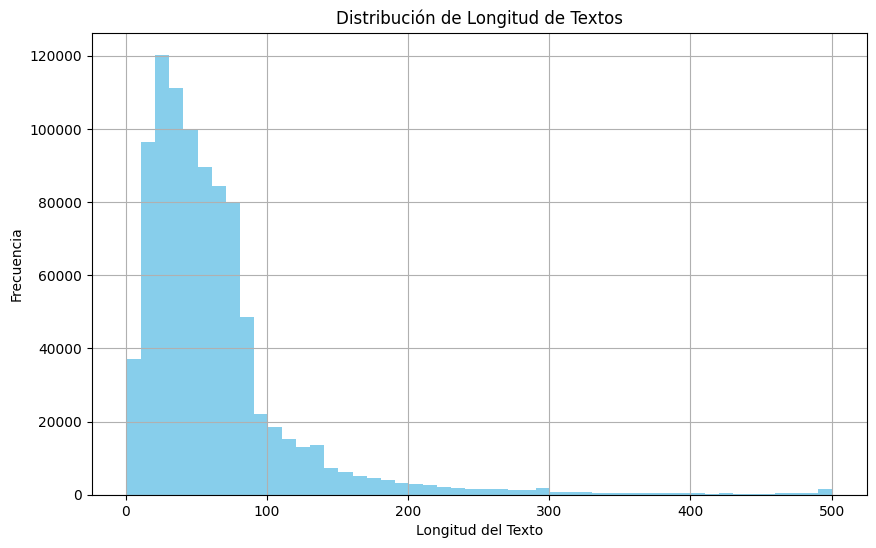

In [15]:
# Análisis de la columna 'text'
print("Resumen de la columna 'text':")
print(df_desanidado['text'].describe())

# Visualización de la longitud de los textos
plt.figure(figsize=(10, 6))
df_desanidado['text'].apply(len).hist(bins=50, color='skyblue')
plt.title('Distribución de Longitud de Textos')
plt.xlabel('Longitud del Texto')
plt.ylabel('Frecuencia')
plt.show()


Resumen de la columna 'date':
count                           908848
mean     2015-06-13 20:57:01.467175680
min                2009-04-16 00:00:00
25%                2013-01-26 00:00:00
50%                2015-03-15 00:00:00
75%                2017-08-02 00:00:00
max                2022-01-19 00:00:00
Name: date, dtype: object


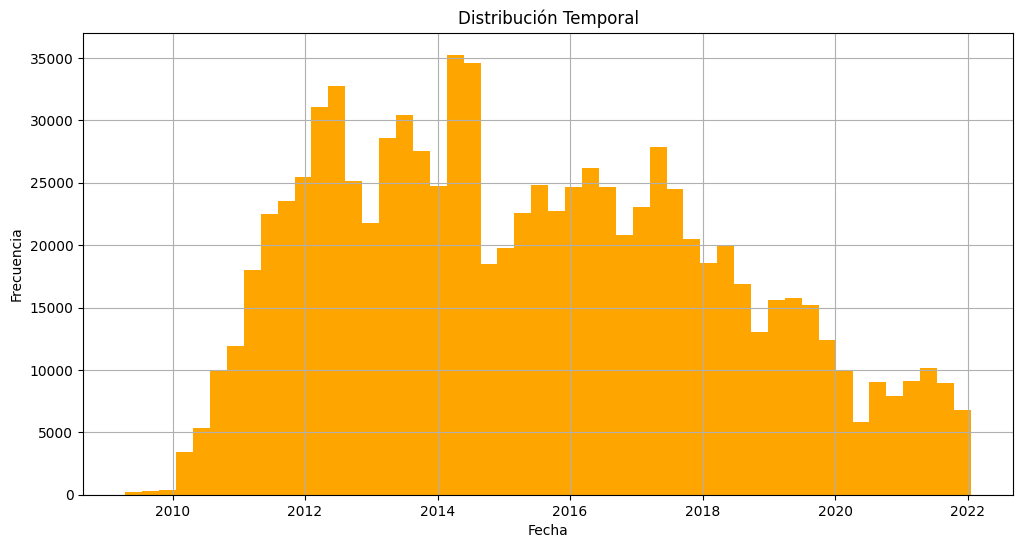

In [16]:
df_desanidado['date'] = pd.to_datetime(df_desanidado['date'], errors='coerce')


print("Resumen de la columna 'date':")
print(df_desanidado['date'].describe())


plt.figure(figsize=(12, 6))
df_desanidado['date'].hist(bins=50, color='orange')
plt.title('Distribución Temporal')
plt.xlabel('Fecha')
plt.ylabel('Frecuencia')
plt.show()

Resumen de la columna 'compliment_count':
count    908848.000000
mean          0.012526
std           0.120768
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           6.000000
Name: compliment_count, dtype: float64


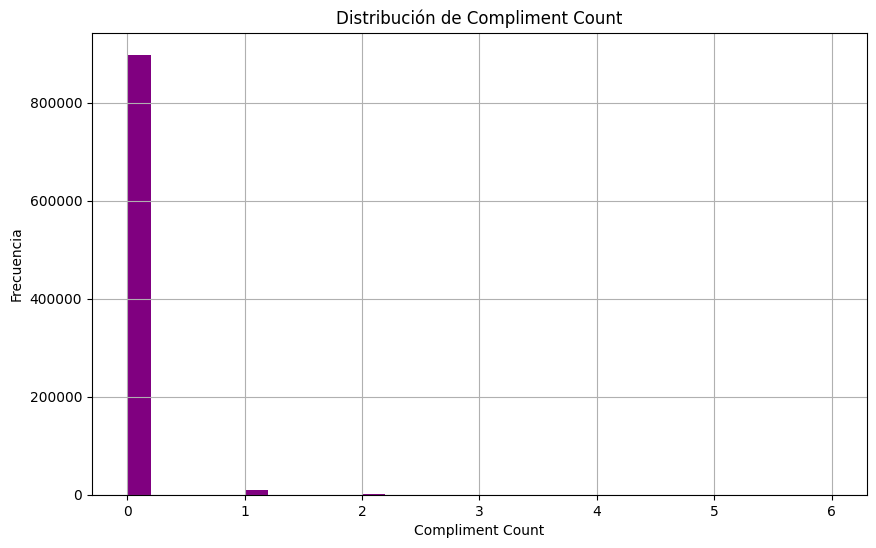

In [17]:
# Análisis de la columna 'compliment_count'
print("Resumen de la columna 'compliment_count':")
print(df_desanidado['compliment_count'].describe())

# Visualización de la distribución de compliment_count
plt.figure(figsize=(10, 6))
df_desanidado['compliment_count'].hist(bins=30, color='purple')
plt.title('Distribución de Compliment Count')
plt.xlabel('Compliment Count')
plt.ylabel('Frecuencia')
plt.show()


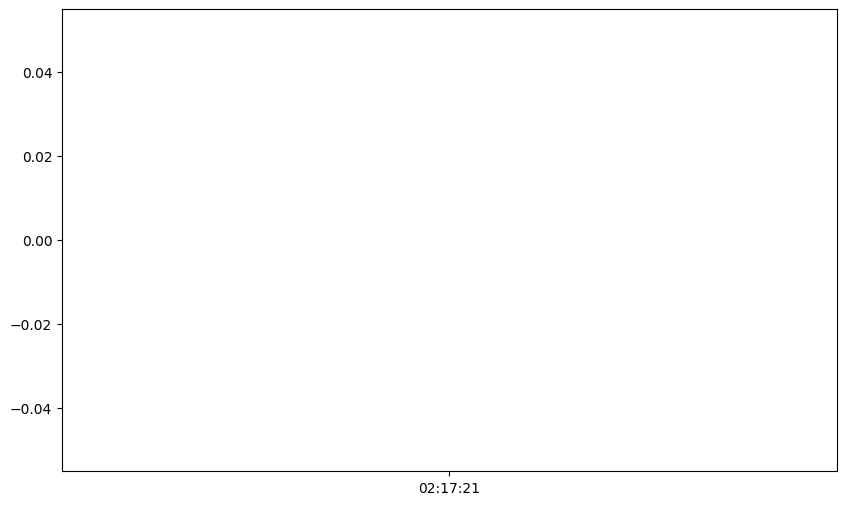

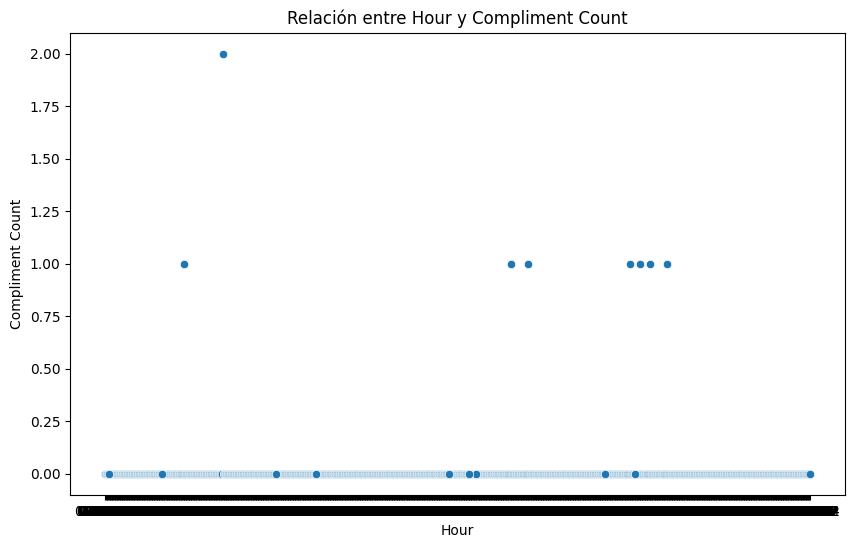

In [19]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='hour', y='compliment_count', data=df_desanidado.sample(1000))  # Muestra de 1000 filas
plt.title('Relación entre Hour y Compliment Count')
plt.xlabel('Hour')
plt.ylabel('Compliment Count')
plt.show()


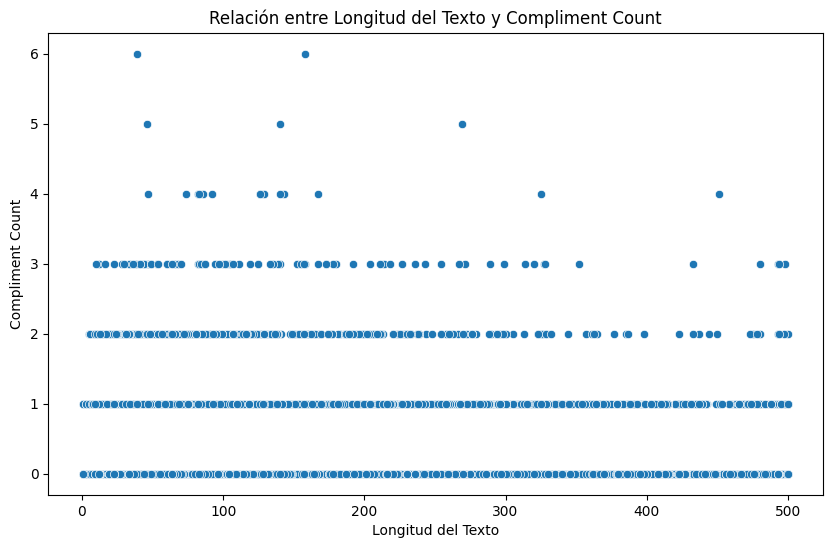

In [20]:
# Crear una nueva columna para la longitud del texto
df_desanidado['text_length'] = df_desanidado['text'].apply(len)

# Gráfico de dispersión entre 'text_length' y 'compliment_count'
plt.figure(figsize=(10, 6))
sns.scatterplot(x='text_length', y='compliment_count', data=df_desanidado)
plt.title('Relación entre Longitud del Texto y Compliment Count')
plt.xlabel('Longitud del Texto')
plt.ylabel('Compliment Count')
plt.show()

     